# Sampling Brownian Motion

In [1]:
#Modules

#JAX
import jax.numpy as jnp
from jax import random as jrandom, vmap, lax, jacfwd

#matplotlib
import matplotlib.pyplot as plt

## Hyper-Parameters

In [2]:
T = 1.0
N_sim = 100
n_steps = 100
seed = 2712
dim = 1

key = jrandom.PRNGKey(seed)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Integration

We use charts below, since we will do an exmaple with the sphere in a moment. For Euclidean simulation the chart is redundant.

In [3]:
#Ito (We can use the same function for Euclidean, just change the drift term)
def integrator_ito(x0, dts, dWs, chart0, sde_fun, chart_fun=None, T=T, n_grid=n_steps):
    
    def step(xt,d):
        
        t, x, chart = xt
        dt, dW = d
        
        (drift, diffusion, xt) = sde_fun(xt,d)
        
        return ((t+dt, *chart_fun(x+drift*dt+diffusion, chart)),)*2
    
    if chart_fun is None:
        chart_fun = lambda x,chart: (x,chart)
        
    _, xs = lax.scan(step, init=(0., x0, chart0), xs=(dts, dWs))    
    
    return xs

In [4]:
#Stratonovich (We can use the same function, just change the drift term)
def integrator_stratonovich(x0, dts, dWs, chart0, sde_fun, chart_fun=None):
    
    def step(xt,d):
        
        t, x, chart = xt
        dt, dW = d
        
        (drift, diffusion, xt) = sde_fun(xt,d)
        _, stox2, _ = sde_fun((t+dt, x+diffusion,chart), d)
        
        return ((t+dt, *chart_fun(x+drift*dt+0.5*(diffusion+stox2), chart)),)*2
    
    if chart_fun is None:
        chart_fun = lambda x,chart: (x,chart)
        
    _, xs = lax.scan(step, init=(0., x0, chart0), xs=(dts, dWs))    
    
    return xs

## Euclidean Stochastic Differential Equations

### Hyper-Parameters

In [5]:
keys = jrandom.split(key,num=N_sim+1)
key = keys[0]
subkeys = keys[1:]

dts = jnp.array([T/n_steps]*n_steps)
dWts = vmap(lambda subkey: jnp.sqrt(dts)[:,None]*jrandom.normal(subkey,(dts.shape[0],dim)))(subkeys).squeeze()

In [6]:
x0 = jnp.ones(1)
chart0 = jnp.zeros(1)

### Orhnstein-Uhlenbeck Process

Recall the Orhnstein-Uhlenbeck Process
\begin{equation}
    dX_{t} = -0.5X_{t}dt + dW_{t}
\end{equation}

Note that if we interpret the last part as Stratonovich, this should be exactly equal to the Ito formulation, since the diffusion term is constant (equal to 1)

In [7]:
def sde_fun(xt, d):
    
    t, x, chart = xt
    dt, dW = d
    
    drift = -0.5*x*dt
    diffusion = dW
    X = drift+diffusion
    
    return (drift, diffusion, X)
    

In [8]:
xs = vmap(lambda dW: integrator_ito(x0, dts, dW, chart0, sde_fun, chart_fun=None, T=T, n_grid=n_steps))(dWts)

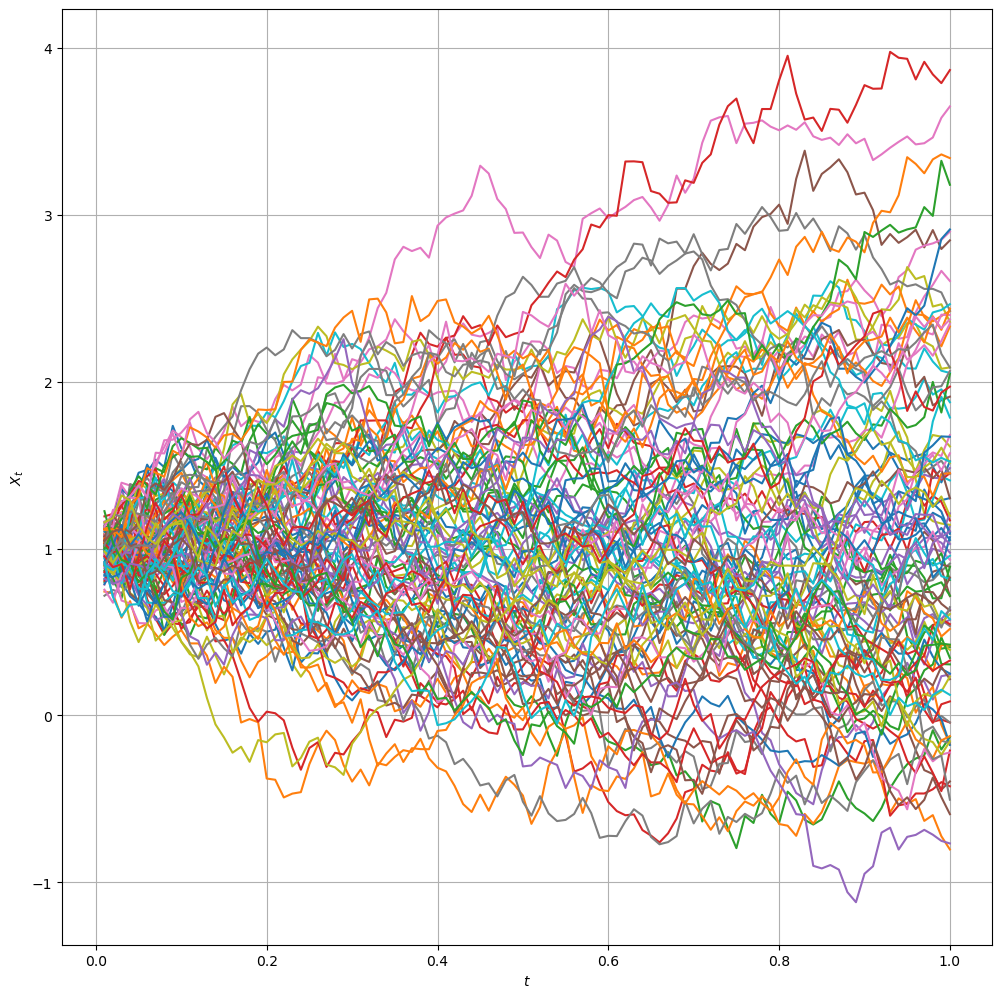

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(xs[0].T, xs[1].squeeze().T)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_{t}$')
fig.savefig('Figures/orhnstein_ito.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')
fig.tight_layout()

In [10]:
xs = vmap(lambda dW: integrator_stratonovich(x0, dts, dW, chart0, sde_fun, chart_fun=None))(dWts)

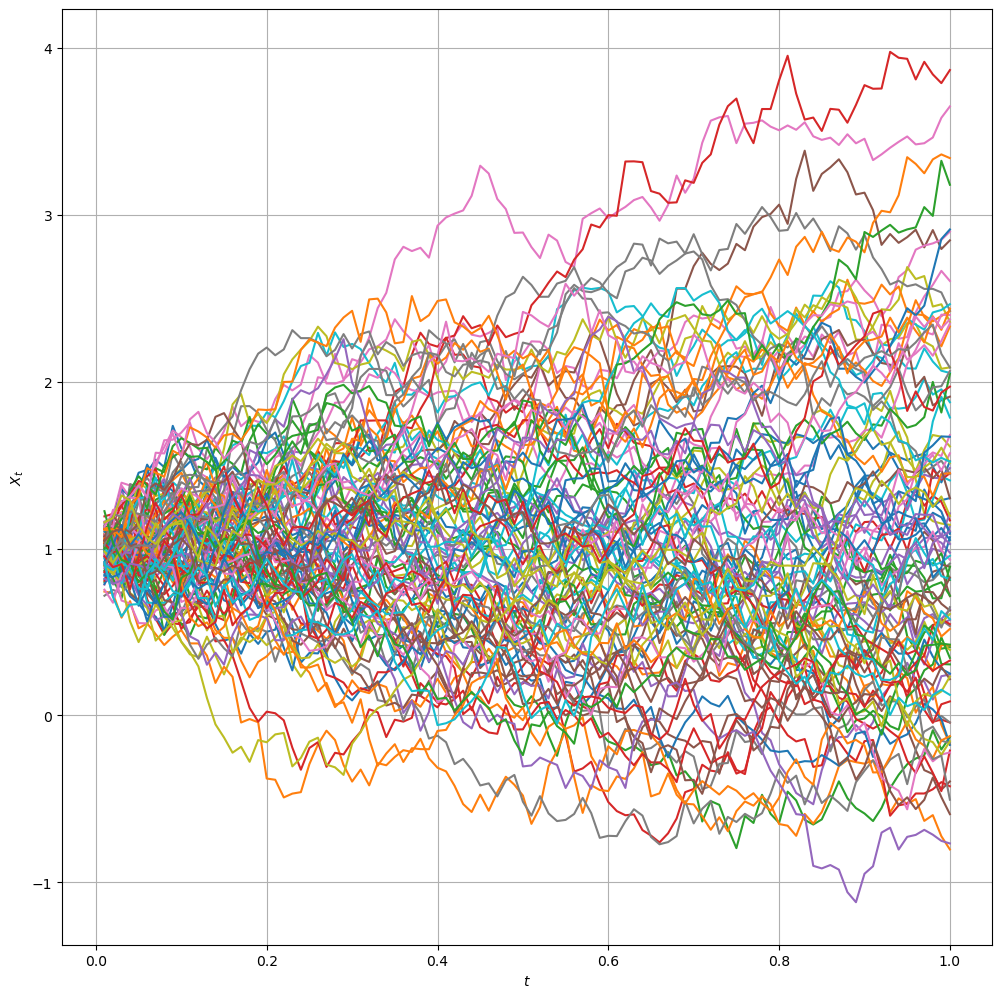

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(xs[0].T, xs[1].squeeze().T)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$X_{t}$')
fig.savefig('Figures/orhnstein_strat.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')
fig.tight_layout()

## Brownian Motion on $\mathbb{S}^{2}$

Now, we will consider Brownian Motion on the sphere, $\mathbb{S}^{2}$, written in steographic coordinates. We will only look at data starting from the north pole to avoid any problems on the south pole, which would require multiple charts (an atlas) to avoid this setting. 

### Defining the chart of the manifold

In [12]:
def F_steographic(x):
            
    s2 = jnp.sum(x**2)

    return jnp.concatenate(((1-s2).reshape(1), 2*x))/(1+s2)
    
def invF_steographic(x):
    
    return vmap(lambda xi: xi/(1+x[0]))(x[1:])

### Hyper-Parameters

In [13]:
dim = 2
N_sim = 10
n_steps = 1000
keys = jrandom.split(key,num=N_sim+1)
key = keys[0]
subkeys = keys[1:]

dts = jnp.array([T/n_steps]*n_steps)
dWts = vmap(lambda subkey: jnp.sqrt(dts)[:,None]*jrandom.normal(subkey,(dts.shape[0],dim)))(subkeys).squeeze()

In [14]:
x0 = jnp.array([0.0,1.0]) #corresponds to the north pole
chart0 = F_steographic(x0)

### Defining the metric

In [15]:
Jf = jacfwd(F_steographic)
Jinvf = jacfwd(invF_steographic)
G = lambda x: Jf(x).T.dot(Jf(x))
DG = jacfwd(G)
Ginv = lambda x: jnp.linalg.inv(G(x))

In [16]:
def Gamma_g(x):
        
    Dgx = DG(x)
    gsharpx = Ginv(x)
    return 0.5*(jnp.einsum('im,kml->ikl',gsharpx,Dgx)
               +jnp.einsum('im,lmk->ikl',gsharpx,Dgx)
               -jnp.einsum('im,klm->ikl',gsharpx,Dgx))

### Brownian Motion in Local Coordinates

In [17]:
def sde_fun(xt, d):
    
    t, x, chart = xt
    dt, dW = d
    
    gsharpx = Ginv(x)
    X = jnp.linalg.cholesky(gsharpx)
    
    drift = -.5*jnp.einsum('kl,ikl->i',gsharpx,Gamma_g(x))
    diffusion = jnp.tensordot(X,dW,(1,0))

    X = drift+diffusion
    
    return (drift, diffusion, X)

In [18]:
xs = vmap(lambda dW: integrator_ito(x0, dts, dW, chart0, sde_fun, 
                                    chart_fun=lambda x,chart: (x, F_steographic(x)), 
                                    T=T, n_grid=n_steps))(dWts)

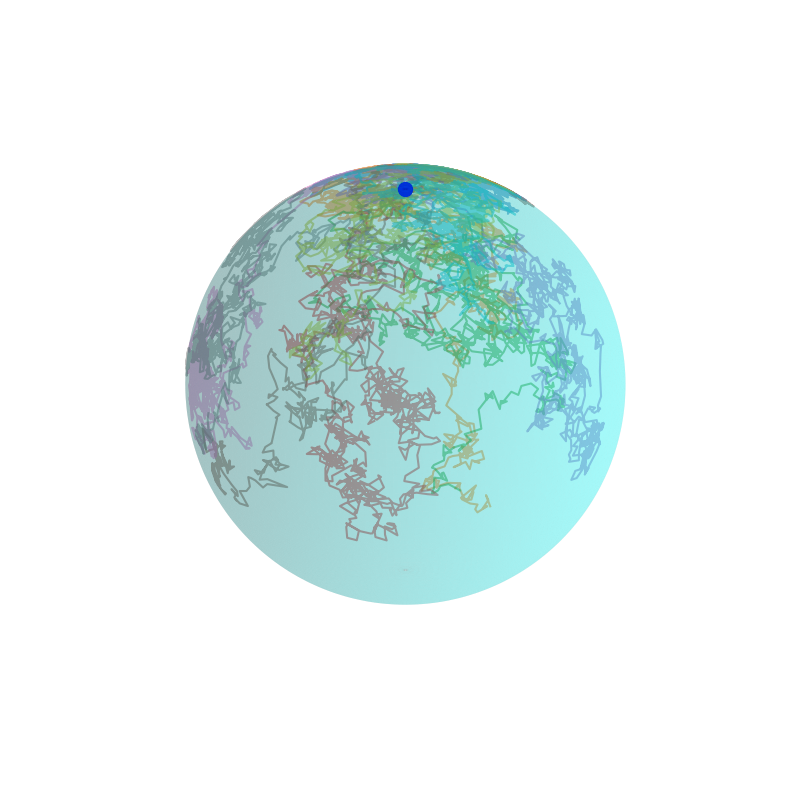

In [19]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(xs[2][:,:,0].T, xs[2][:,:,1].T, xs[2][:,:,2].T, color='black', alpha=1.0)
ax.scatter(chart0[0], chart0[1], chart0[2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(xs[2][i,:,0], xs[2][i,:,1], xs[2][i,:,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_coordinates.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

### Brownian Motion in the Tangent Space

In [20]:
dim = 3 #Do the computation in the embedded space
keys = jrandom.split(key,num=N_sim+1)
key = keys[0]
subkeys = keys[1:]

dts = jnp.array([T/n_steps]*n_steps)
dWts = vmap(lambda subkey: jnp.sqrt(dts)[:,None]*jrandom.normal(subkey,(dts.shape[0],dim)))(subkeys).squeeze()

In [21]:
#Projection of vector v in R^3 onto the tangent space TxM (will keep Gaussian distributions)
def proj_to_TM(x, v):
    
    return v-jnp.dot(v,x)*x

In [22]:
#Exponential Map on sphere
def Exp(x,v):
    
    normv = jnp.sqrt(jnp.dot(v,v))
    
    return jnp.cos(normv)*x+jnp.sin(normv)*v/normv

In [23]:
#Now the sde_function is defined in the tangent space
def tangent_space_simulation(chart0, dts, dWs):
    
    def step(xt, d):
        
        t,chart = xt
        
        dt, dW = d
        
        proj_dW = proj_to_TM(chart, dW) #Make sure that the brownian term is in the tangent space
        X = Exp(chart, proj_dW)
        
        return ((t+dt, X), )*2
    
    _, xs = lax.scan(step, init=(0., chart0), xs=(dts, dWs))
    
    return xs
    

In [24]:
xs = vmap(lambda dW: tangent_space_simulation(chart0, dts, dW))(dWts)

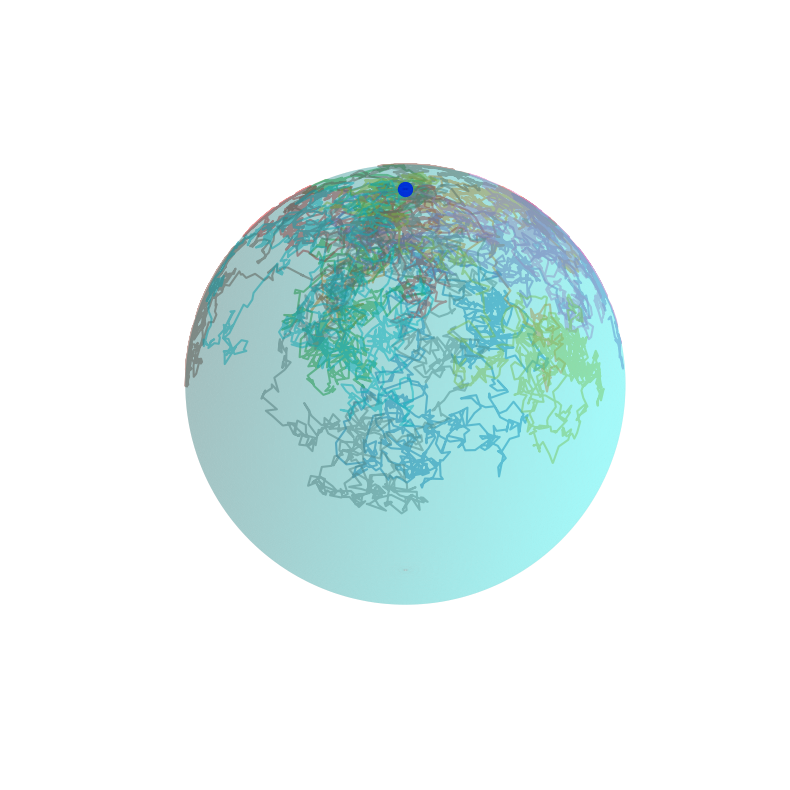

In [25]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(xs[2][:,:,0].T, xs[2][:,:,1].T, xs[2][:,:,2].T, color='black', alpha=1.0)
ax.scatter(chart0[0], chart0[1], chart0[2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(xs[1][i,:,0], xs[1][i,:,1], xs[1][i,:,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_tangent.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

### Brownian Motion by the Projection Operator

In [26]:
dim = 3 #Do the computation in the embedded space
keys = jrandom.split(key,num=N_sim+1)
key = keys[0]
subkeys = keys[1:]

dts = jnp.array([T/n_steps]*n_steps)
dWts = vmap(lambda subkey: jnp.sqrt(dts)[:,None]*jrandom.normal(subkey,(dts.shape[0],dim)))(subkeys).squeeze()

In [27]:
def sde_fun(xt, d):
    
    t, x, chart = xt
    dt, dW = d

    #proj_dW = proj_to_TM(x, dW) #Make sure that the brownian term is in the tangent space
    drift = jnp.zeros(3)
    diffusion = jnp.eye(3)-jnp.einsum('i,j->ij', x, x)
    diffusion = jnp.tensordot(diffusion,dW,(1,0))

    X = drift+diffusion
    
    return (drift, diffusion, X)

In [28]:
xs = vmap(lambda dW: integrator_stratonovich(chart0, dts, dW, jnp.zeros(1), sde_fun, 
                                            chart_fun=None))(dWts)

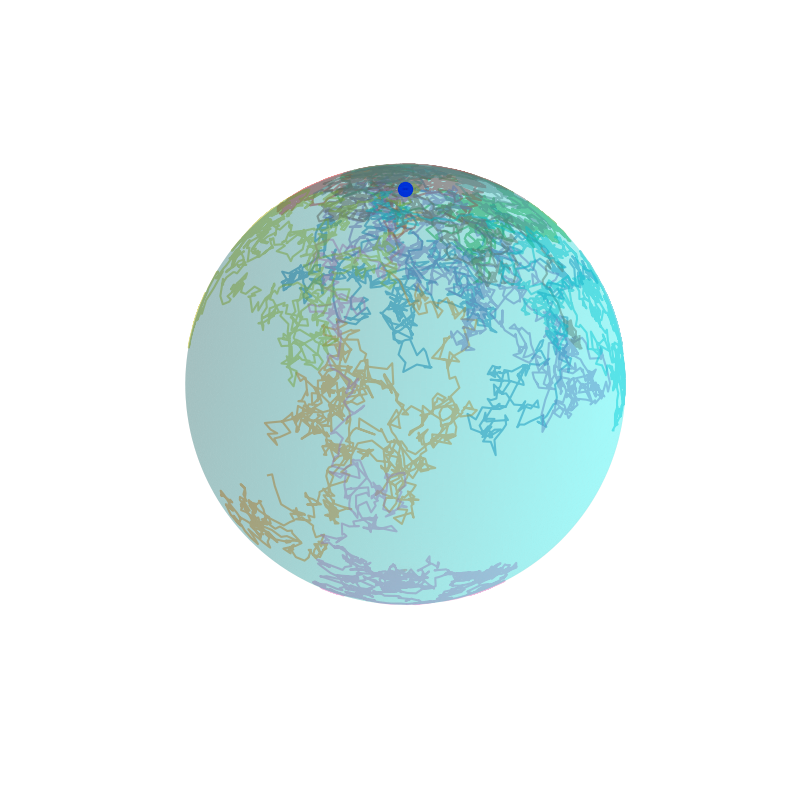

In [29]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(xs[2][:,:,0].T, xs[2][:,:,1].T, xs[2][:,:,2].T, color='black', alpha=1.0)
ax.scatter(chart0[0], chart0[1], chart0[2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(xs[1][i,:,0], xs[1][i,:,1], xs[1][i,:,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_true_proj.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

### Computing the Projection Map using An Orthonormal Basis of the Jacobian

In [30]:
dim = 3 #Do the computation in the embedded space
keys = jrandom.split(key,num=N_sim+1)
key = keys[0]
subkeys = keys[1:]

dts = jnp.array([T/n_steps]*n_steps)
dWts = vmap(lambda subkey: jnp.sqrt(dts)[:,None]*jrandom.normal(subkey,(dts.shape[0],dim)))(subkeys).squeeze()

In [31]:
def sde_fun(xt, d):
    
    t, x, chart = xt
    dt, dW = d
    
    x_local = invF_steographic(x)
    
    J = Jf(x_local)
    Q, _ = jnp.linalg.qr(J)

    drift = jnp.zeros(3)
    diffusion = jnp.tensordot(jnp.dot(Q,Q.T),dW,(1,0))

    X = drift+diffusion
    
    return (drift, diffusion, X)

In [32]:
U, _ = jnp.linalg.qr(Jf(x0))
U_proj = jnp.dot(U, U.T)

In [33]:
xs = vmap(lambda dW: integrator_stratonovich(chart0, dts, dW, jnp.zeros(1), sde_fun, 
                                            chart_fun=None))(dWts)

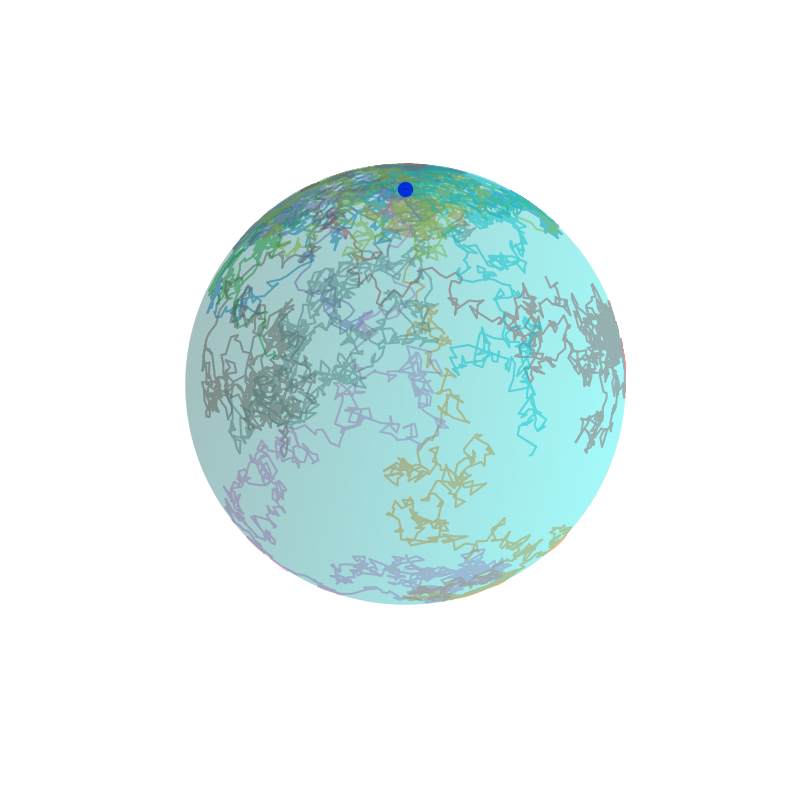

In [34]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(xs[2][:,:,0].T, xs[2][:,:,1].T, xs[2][:,:,2].T, color='black', alpha=1.0)
ax.scatter(chart0[0], chart0[1], chart0[2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(xs[1][i,:,0], xs[1][i,:,1], xs[1][i,:,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_approx_proj.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

### Computing Estimating the Exponential Map by Geodesic Shooting

In [35]:
dim = 3 #Do the computation in the embedded space
keys = jrandom.split(key,num=N_sim+1)
key = keys[0]
subkeys = keys[1:]

dts = jnp.array([T/n_steps]*n_steps)
dWts = vmap(lambda subkey: jnp.sqrt(dts)[:,None]*jrandom.normal(subkey,(dts.shape[0],dim)))(subkeys).squeeze()

In [36]:
#Projection of vector v in R^3 onto the tangent space TxM (will keep Gaussian distributions)
def proj_to_TM(x, v):
    
    x_local = invF_steographic(x)
    J = Jf(x_local)
    Q, _ = jnp.linalg.qr(J)
    
    proj = jnp.dot(Q, Q.T)
    
    return jnp.dot(proj, v)

In [37]:
#Exponential Map on sphere
def Exp(x,v, nsteps=1000):
    
    def step(carry, idx):
        
        x, v = carry
        
        x += delta*v
        z = invF_steographic(x)
        x = F_steographic(z)
        Q, _ = jnp.linalg.qr(Jf(z))
        vi = jnp.dot(jnp.dot(Q,Q.T), v)
        vi *= jnp.sqrt(jnp.dot(vi,vi))/jnp.sqrt(jnp.dot(v,v))
        
        return ((x,v),)*2
    
    
    delta = 1/nsteps
    
    _, xs = lax.scan(step, init=(x,v), xs = jnp.ones(n_steps))
    
    return xs[0]

In [38]:
#Now the sde_function is defined in the tangent space
def tangent_space_simulation(chart0, dts, dWs):
    
    def step(xt, d):
        
        t,chart = xt
        
        dt, dW = d
        
        proj_dW = proj_to_TM(chart, dW) #Make sure that the brownian term is in the tangent space
        X = Exp(chart, proj_dW)[-1]
        
        return ((t+dt, X), )*2
    
    _, xs = lax.scan(step, init=(0., chart0), xs=(dts, dWs))
    
    return xs
    

In [39]:
xs = vmap(lambda dW: tangent_space_simulation(chart0, dts, dW))(dWts)

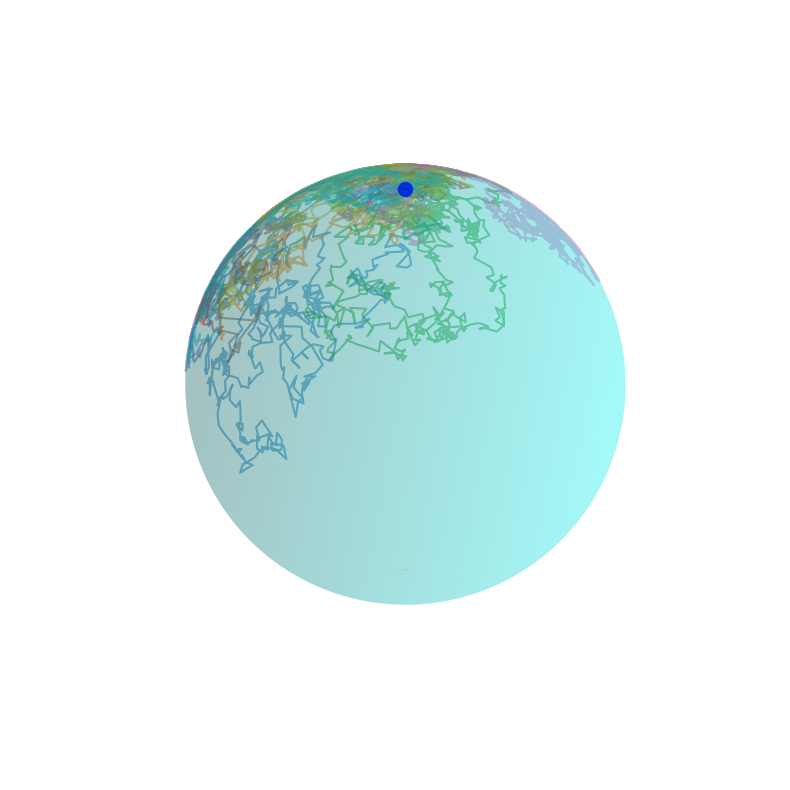

In [40]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(xs[2][:,:,0].T, xs[2][:,:,1].T, xs[2][:,:,2].T, color='black', alpha=1.0)
ax.scatter(chart0[0], chart0[1], chart0[2], color='blue', alpha=1.0, s=100)
for i in range(N_sim):
    ax.plot3D(xs[1][i,:,0], xs[1][i,:,1], xs[1][i,:,2], alpha=0.5)#, color='red', alpha=0.6)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('Figures/s2_approx_exp.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()